### Contexto 

A fintech de Crédito XX iniciou sua operação de concessão de empréstimo pessoal e acompanhou a performance de pagamento de clientes após 1 ano. Ela pede para verificar quais os fatores de risco dos clientes de forma a conseguir aprovar mais contratos com a menor inadimplência possível.
Com base nessas informações:

Quais fatores de risco estão mais associados a inadimplência? Com isso, o que a fintech deveria mudar de forma a minimizar a inadimplência?
Crie uma forma de atribuir a probabilidade de inadimplência para cada cliente da base usando os fatores de risco identificados.
Discuta um corte nessa probabilidade de forma a aprovar clientes apenas acima do corte. Se isso acontecer, qual a probabilidade de inadimplência esperada e qual a proporção de clientes aprovados esperada?

### Estrutura da analise 


   1) Analise exploratoria
       - Identificação dos tipos de variaveis.
       - Identificação de valores ausentes.
       - Analise bi variada para possiveis correlações entre variaveis               numericas.
       - Possiveis variaveis com influencisa de outliers.
         
   
   
   2) Analise IV
       - Analisar matematicamente a influencia de cada categoria na                    variavel de interesse.
       
   
   
   3) Analise regressao logistica com modelo estatistico 
       - objetivo de ver a influencia estatística de cada variavel na                 inadimplência. 
    
   
   
   4) Analise preditiva por machinie learning
       - objetivo de fazer uma previsão de novos inadimplentes. 
    

### Conclusão 


##### Dentre os maiores fatores encontrados que contribuem para a inadimplencia estão:  



Idade    :  quanto maior a idade menor a chance de se tornar inadimplente                 
Sexo_Mulher : fator mulher diminui a chance de se tornar inadimplente               
Escolaridade_Graduação : Ter graduação diminui a channce da pessoa se                                 tornar inadimplente a um nivel de significancia                              de 10%

Tipo_Moradia_ Propria : Ter moradia propria diminui a chance de se tornar                            inadimplente          



Saldo_Conta_Corrente (moderado e pouco) : Aumentam a chance de se tornar                                              inadimplente 
     
Duracao_Emprestimo : A medida que aumenta a duração aumenta a chance de se                         tornar inadimplente    



Temos 590 pessoas que ainda não estao inadimplentes porém que possuem mais de 20% de chance de inadimplencia.

25% da base possui mais de 37% de chance de se tornar inadimplente.

Se tomarmos aceitavel dar imprestimo a pessoas que possuem uma probabilidade de no maximo 11% de se tornar inadimplente, concederiamos imprestimos a 203 pessoas.



Medidas a adotar:

1) Realizar um acompanhamento de perto dos clientes que já possuem empréstimo com conta corrente pouca e média com parcelas maiores de 22 meses. 
2) Ofertar empréstimo com foco em clientes mulheres, que possuam escolaridade graduação e que possuem uma conta corrente alta.  











### Carregamento de pacotes 

In [1]:
import pandas as pd
import numpy as np


# Pacotes gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz
from plotnine import*
import matplotlib.pyplot as plt

# Pacotes de modelagem
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import recall_score


from sklearn.model_selection import train_test_split

# Módulo de Análise Exploratória
import aed
from ydata_profiling import ProfileReport


from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.datasets import load_iris  # Exemplo com o dataset Iris
import graphviz
import pydotplus
from IPython.display import Image



import imblearn


import statsmodels.api as sm

import preditiva


C:\Users\tania\anaconda3\Lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
C:\Users\tania\anaconda3\Lib\site-packages\visions\backends\shared\nan_handling.py:50: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


### Ajuste do banco de dados

In [2]:
#Leitura de dados
df = pd.read_excel("Base_Inadimplencia.xlsx", sheet_name=1)

In [24]:
#df.columns
#df.dtypes
#df.isnull().sum()
#df.index.duplicated().sum()
df.info()
#print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Idade                 1000 non-null   int64 
 1   Sexo                  1000 non-null   object
 2   Escolaridade          1000 non-null   object
 3   Tipo_Moradia          1000 non-null   object
 4   Saldo_Investimento    1000 non-null   object
 5   Saldo_Conta_Corrente  1000 non-null   object
 6   Valor_Emprestimo      1000 non-null   int64 
 7   Duracao_Emprestimo    1000 non-null   int64 
 8   Inadimplencia         1000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


In [12]:
#df['Inadimplencia'] = df['Inadimplencia'].astype('category')

##### Grafico de contagem inadimplencia 

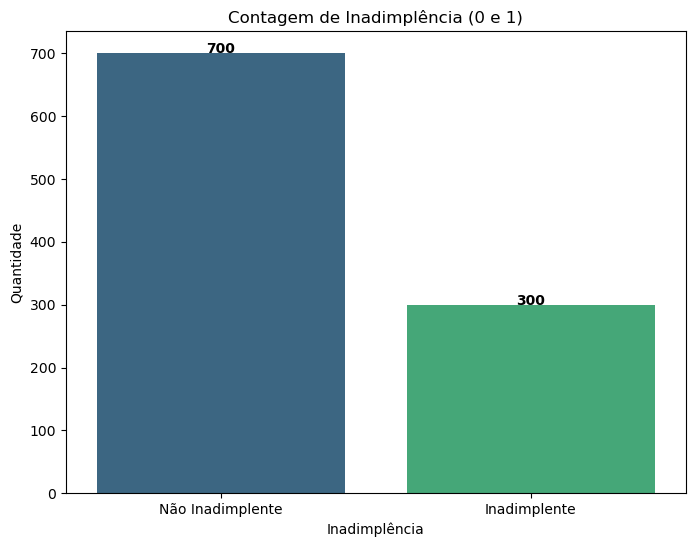

In [41]:
contagem = df['Inadimplencia'].value_counts()

# Criar gráfico de barras
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=contagem.index, y=contagem.values, palette="viridis")

# Adicionar contagens nas barras
for i, v in enumerate(contagem.values):
    ax.text(i, v + 0.1, str(v), ha='center', fontweight='bold')

# Adicionar rótulos e título
plt.xlabel("Inadimplência")
plt.ylabel("Quantidade")
plt.title("Contagem de Inadimplência (0 e 1)")
plt.xticks([0, 1], ["Não Inadimplente", "Inadimplente"])

# Exibir o gráfico
plt.show()

Nota: Apesar da base de inadimplência nao possuir uma descrepancia nas categorias, posuindo uma proporção 70% não inadimplente e 30% inadimplentes. Ainda sim devemos usar alguma metodologia para base de dados desbalanceadas.

### Analise exploratoria

###### ANALISE EXPLORATÓRIA RESUMO:

A partir do relatório gerado observamos inicialmente uma alta correlação das variáveis "duração do empréstimo" e "valor do empréstimo". trazendo a informação que, para adiante, quando formos fazer a análise de regressão logística optemos por uma ou por outra variável para não ocasionar multicolinearidade.

Logo após podemos ver um valor de information value (IV) significativo entre as categorias da variável "saldo em conta corrente" sendo a mais significativa: 'sem conta' seguido de 'pouco'. A variável 'saldo investimento' também possui nível de IV significativo. Isso que dizer que os grupos dessa variável não são homogêneos em relação a variável inadimplência, ou seja, existe alguma relaçao das categorias com a inadimplencia.

Foi gerado tambem os graficos box-plot das variaveis continuas para identificação de out-liers. Constando que não temos muitos valores descrepantes.

#### Relatorio Profile Report

In [3]:
Relatorio = ProfileReport(df, title="Relatório Inadimplência")
Relatorio

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

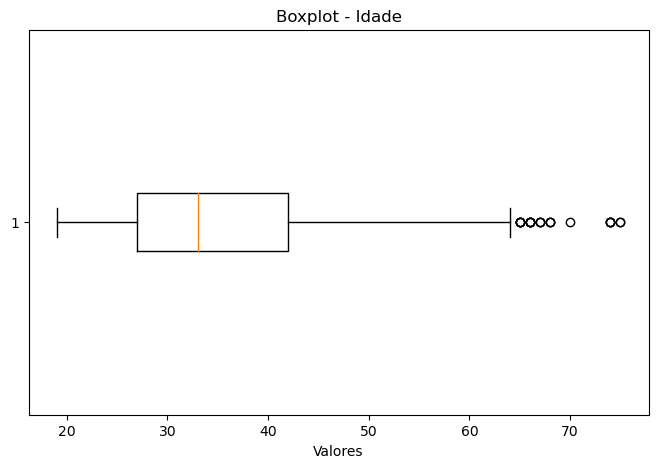

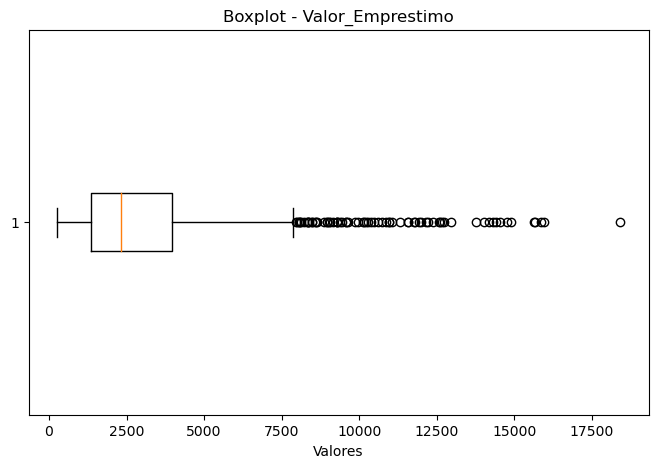

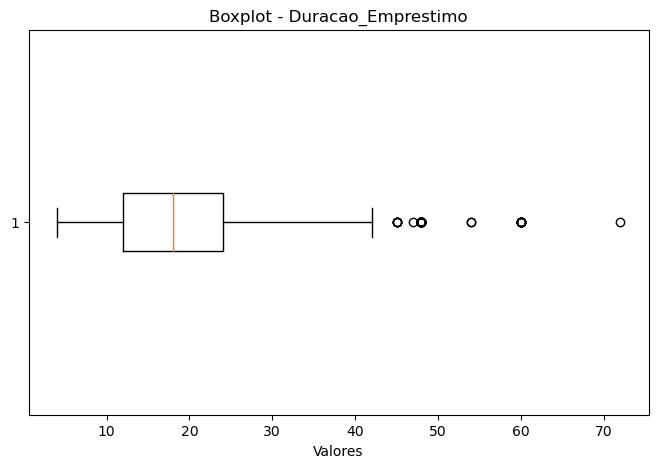

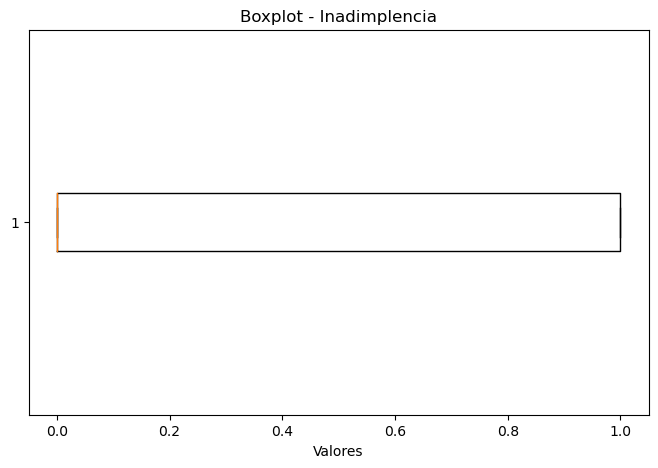

In [6]:
import matplotlib
matplotlib.use('Agg') 
%matplotlib inline
# Percorre todas as colunas do DataFrame
for coluna in df.columns:
    # Verifica se a coluna contém valores inteiros
    if pd.api.types.is_integer_dtype(df[coluna]):
        plt.figure(figsize=(8, 5))
        plt.boxplot(df[coluna].dropna(), vert=False)
        plt.title(f'Boxplot - {coluna}')
        plt.xlabel('Valores')
        plt.show()

C:\Users\tania\AppData\Local\Temp\ipykernel_7728\2802771126.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


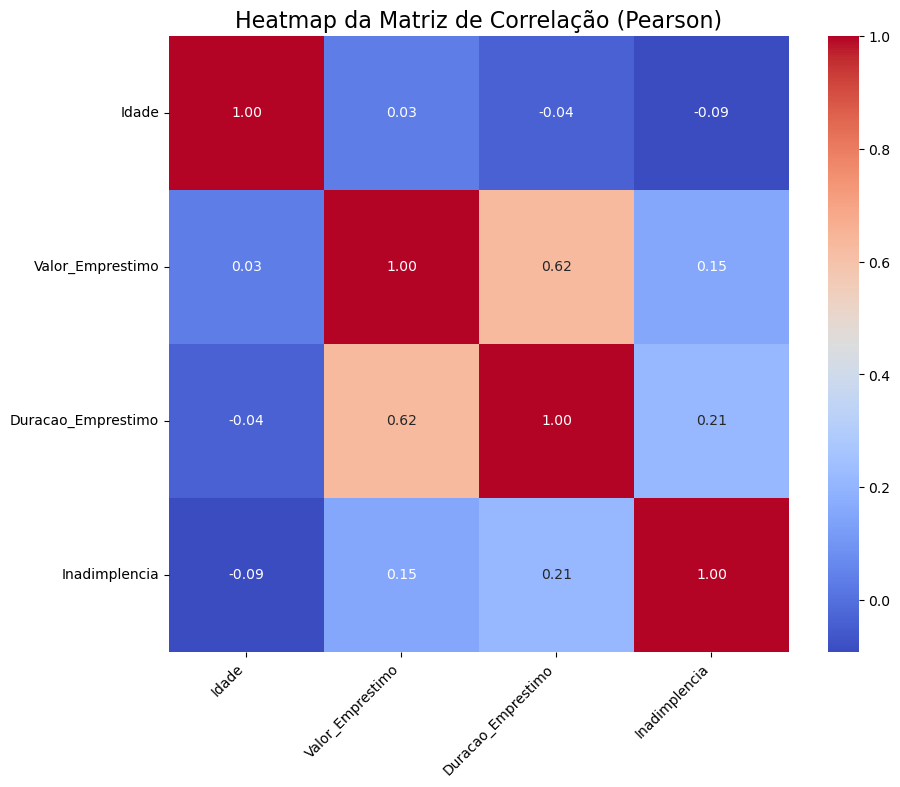

In [7]:
correlation_matrix = df.corr(method="pearson")
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# Configuração do tamanho do gráfico
plt.figure(figsize=(10, 8))

# Criando o heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

# Ajustes e título
plt.title("Heatmap da Matriz de Correlação (Pearson)", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

#### Analise bivariada Information value (IV)

Atenção: A analise IV não funciona com a variavel de referencia categorica. Tem que ser inteira.

In [19]:
df_iv = aed.analise_iv(df,'Inadimplencia')
df_iv.get_lista_iv()

C:\Users\tania\Desktop\Git-Hub\Financial_Technology\Financial_Technology\aed.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Inadimplencia,IV
Variavel,
Saldo_Conta_Corrente,0.73
Duracao_Emprestimo,0.25
Saldo_Investimento,0.20
Valor_Emprestimo,0.11
Idade,0.09
Tipo_Moradia,0.09
Sexo,0.03
Escolaridade,0.01


In [20]:
df_iv.get_bivariada(var_escolhida='Saldo_Conta_Corrente')

==> "Saldo_Conta_Corrente" tem IV de 0.73


Inadimplencia,Variavel,Var_Range,#Target_1,#Target_0,Total,%Freq,%Target_1,%Target_0,%Taxa_de_Target_1,Odds,LN(Odds),IV
0,Saldo_Conta_Corrente,Alto,21,87,108,10.8,7.00,12.43,19.44,0.56,-0.58,0.03
1,Saldo_Conta_Corrente,Moderado,98,126,224,22.4,32.67,18.00,43.75,1.82,0.60,0.09
2,Saldo_Conta_Corrente,Pouco,135,139,274,27.4,45.00,19.86,49.27,2.27,0.82,0.21
3,Saldo_Conta_Corrente,Sem conta,46,348,394,39.4,15.33,49.71,11.68,0.31,-1.17,0.40


In [22]:
df_iv.get_bivariada(var_escolhida='Saldo_Investimento')

==> "Saldo_Investimento" tem IV de 0.2


Inadimplencia,Variavel,Var_Range,#Target_1,#Target_0,Total,%Freq,%Target_1,%Target_0,%Taxa_de_Target_1,Odds,LN(Odds),IV
0,Saldo_Investimento,Alto,17,94,111,11.1,5.67,13.43,15.32,0.42,-0.87,0.07
1,Saldo_Investimento,Moderado,34,69,103,10.3,11.33,9.86,33.01,1.15,0.14,0.00
2,Saldo_Investimento,Pouco,217,386,603,60.3,72.33,55.14,35.99,1.31,0.27,0.05
3,Saldo_Investimento,Sem investimento,32,151,183,18.3,10.67,21.57,17.49,0.49,-0.71,0.08


#### Box plot Inadimplencia VS valor_Emprestimo / Duracao_Emprestimo 

<Axes: xlabel='Inadimplencia', ylabel='Valor_Emprestimo'>

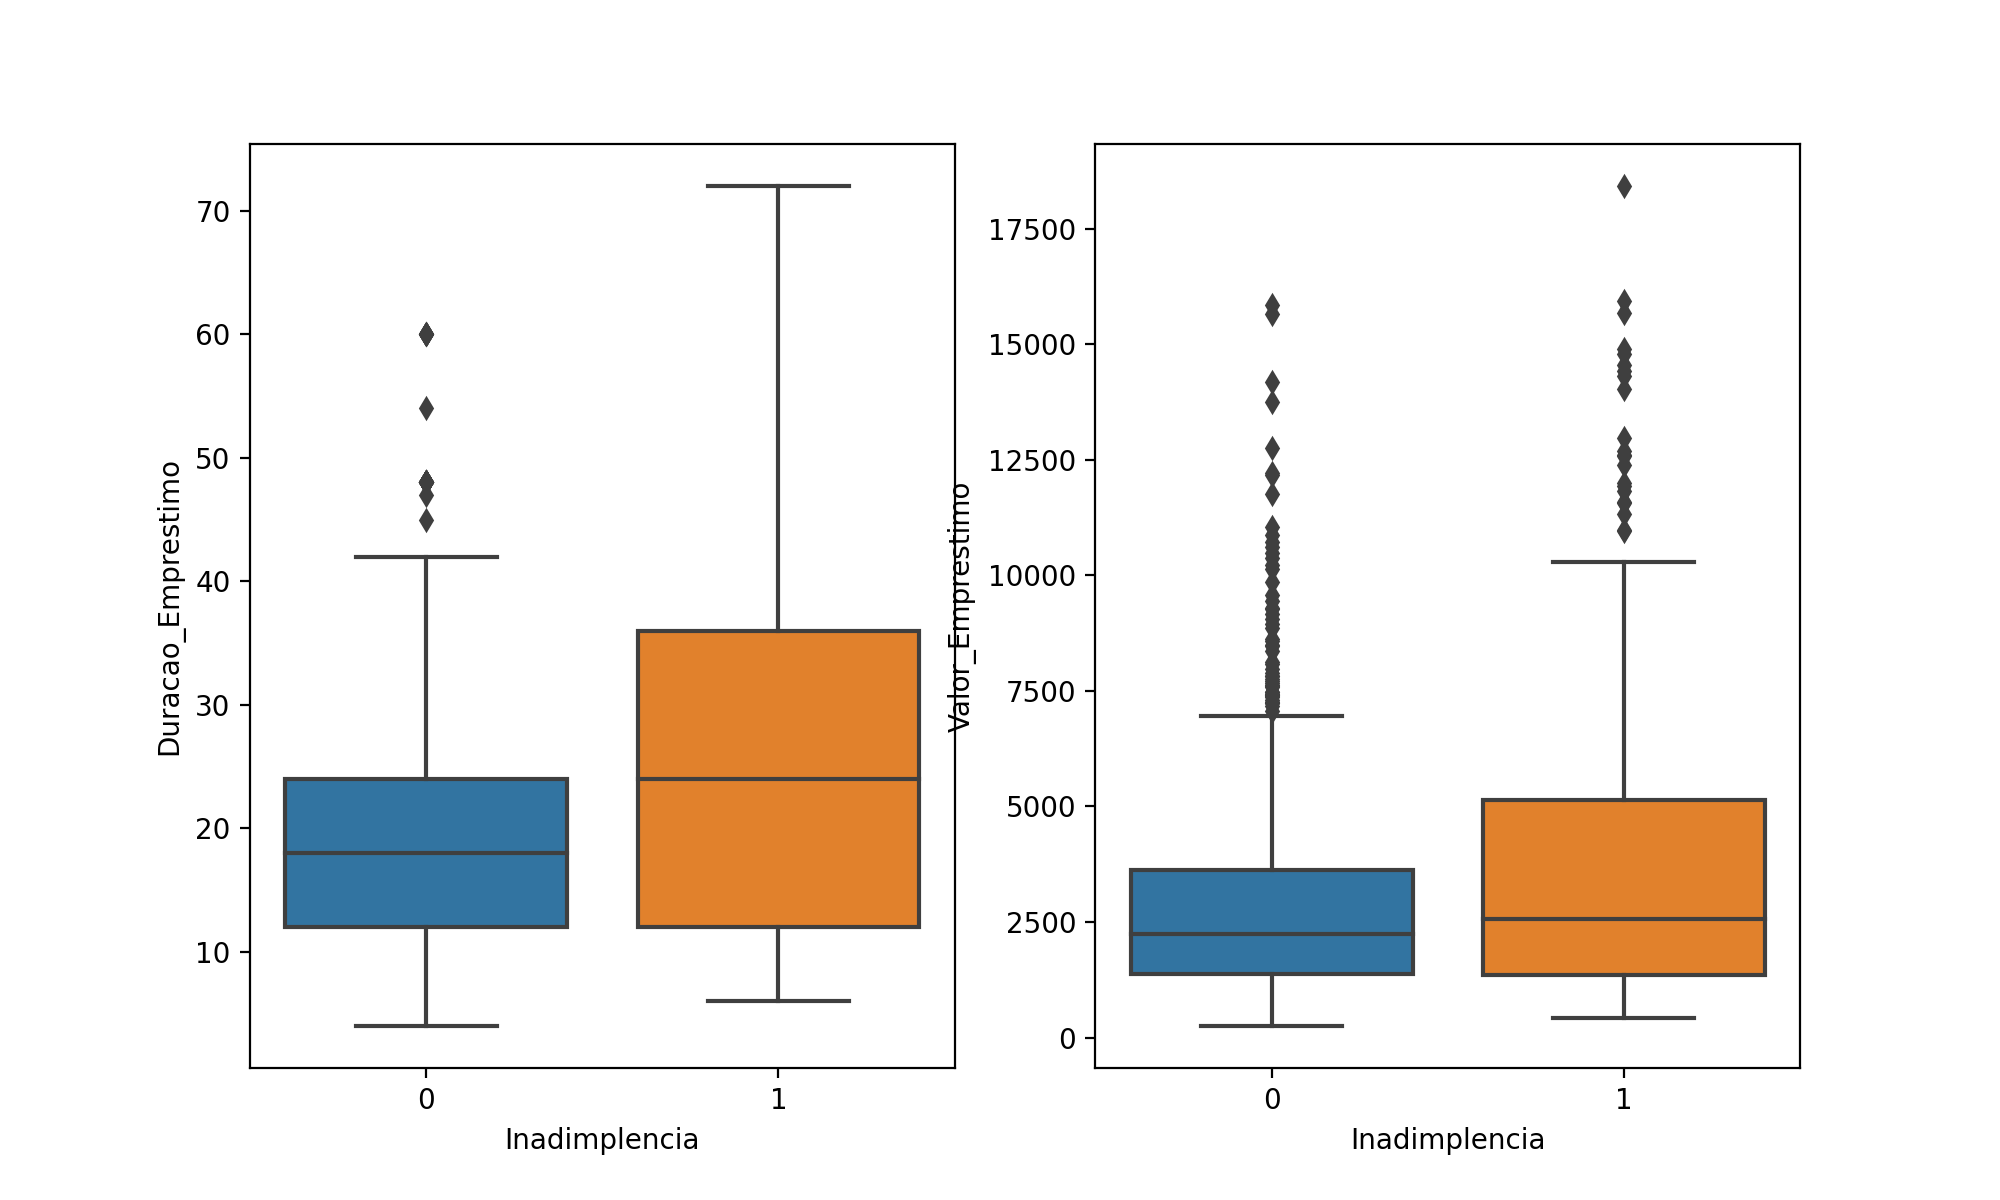

In [40]:

plt.figure(figsize=(10, 6))  # Define o tamanho da figura

plt.subplot(1, 2, 1)  # Cria o primeiro subplot para a variável 
sns.boxplot(x='Inadimplencia', y='Duracao_Emprestimo', data=df)

plt.subplot(1, 2, 2)  # Cria o segundo subplot para a variável 
sns.boxplot(x='Inadimplencia', y='Valor_Emprestimo', data=df)


##  Regressão Logistica para atribuição do score 

##### INTERPRETAÇÃO DA REGRESSÃO LOGISTICA:
A partir do modelo logístico de regressão gerada pelo 'statsmodels' apodemos observar que as variáveis mais relacionadas com a inadimplência são: 

idade, reduzindo a cada ano 2% a chance de ser inadimplente.
duração empréstimo, aumentando, a cada mês, em 3% a chance de ser inadimplente.
sexo 'mulher', diminuindo em 32% a chance de ser inadimplente.
escolaridade 'graduação', diminui em 29% a chance de ser inadimplente.
tipo de moradia 'própria', diminui em 32% a chance de ser inadimplente
saldo em conta corrente 'moderado', aumenta em 62% a chance  de ser inadimplente
saldo em conta corrente 'pouco', aumenta em 122% a chance de ser inadimplente
saldo em conta corrente 'sem conta corrente', diminui em 65% a chance de ser inadimplente


O pseudo r2 do modelo feito pelo 'statsmodels' deu uma valor de 0,16. significa que o modelo explica uma parcela relativamente pequena da variabilidade dos dados.  (mas isso não implica automaticamente em uma má capacidade de previsão.)

Já para a o modelo logístico para classificação realizado com o 'sklearn' possuiu uma performance melhor, com uma precisão de 0,57 e um recall de 0,35. em seguido foi criada uma variável chamada 'probabilidade inadimplência' para cada cliente e anexada ao no banco de dados.

##### NOTA: 
Com que insights criar um corte na probabilidade? e como calcular a inadimplência esperada e a quantidade de clientes aprovados?

In [21]:
#Separeando variaveis resposta e criando variaveis dummies 


y= df['Inadimplencia']

df2 = df.drop(columns=['Inadimplencia','Valor_Emprestimo'])

#Para analise de regressao logistica é necessario excluir a primeira classe de dummies
df_modelo_l = pd.get_dummies(df2, drop_first=True) 
df_modelo_l

,Idade,Duracao_Emprestimo,Sexo_M,Escolaridade_Graduacao,Escolaridade_Pos Graduacao,Tipo_Moradia_De favor,Tipo_Moradia_Propria,Saldo_Investimento_Moderado,Saldo_Investimento_Pouco,Saldo_Investimento_Sem investimento,Saldo_Conta_Corrente_Moderado,Saldo_Conta_Corrente_Pouco,Saldo_Conta_Corrente_Sem conta
0,67,6,1,1,0,0,1,0,0,1,0,1,0
1,22,48,0,1,0,0,1,0,1,0,1,0,0
2,49,12,1,0,1,0,1,0,1,0,0,0,1
3,45,42,1,1,0,1,0,0,1,0,0,1,0
4,53,24,1,1,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,31,12,0,0,1,0,1,0,1,0,0,0,1
996,40,30,1,0,0,0,1,0,1,0,0,1,0
997,38,12,1,1,0,0,1,0,1,0,0,0,1
998,23,45,1,1,0,1,0,0,1,0,0,1,0


## Modelo estatistico com statsmodel

In [22]:
#Criando o modelo de regressão logística usando statsmodels para analise dos coeficientes 
import statsmodels.api as sm

modelo_l = sm.Logit(y, df_modelo_l)
resultado = modelo_l.fit()

# Imprimir a saída detalhada
print(resultado.summary())



Optimization terminated successfully.
         Current function value: 0.511653
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          Inadimplencia   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      987
Method:                           MLE   Df Model:                           12
Date:                Mon, 16 Dec 2024   Pseudo R-squ.:                  0.1624
Time:                        16:39:29   Log-Likelihood:                -511.65
converged:                       True   LL-Null:                       -610.86
Covariance Type:            nonrobust   LLR p-value:                 6.902e-36
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Idade                                  -0.0248      0.007 

In [52]:
print("Idade:", 1- np.exp(-0.0248))
print("Duracao_Emprestmo:", np.exp(0.0302))
print("Sexo_M:", 1-np.exp(-0.4037)) 
print("Escolaridade_Graduacao:", 1- np.exp(-0.3178))
print("Tipo_Moradia_Propria:", 1- np.exp(-0.4476))
print("Saldo_Conta_Corrente_Moderado:", np.exp(0.4644))
print("Saldo_Conta_Corrente_Pouco:", np.exp(0.7883))
print("Saldo_Conta_Corrente_Sem conta:", 1- np.exp(-1.0744))

Idade: 0.02449500648176295
Duracao_Emprestmo: 1.0340674437262785
Sexo_M: 0.32800205735241106
Escolaridade_Graduacao: 0.2957345963166266
Tipo_Moradia_Propria: 0.36383670789275624
Saldo_Conta_Corrente_Moderado: 1.6290548499725743
Saldo_Conta_Corrente_Pouco: 2.2242060044526317
Saldo_Conta_Corrente_Sem conta: 0.6527811478489736


In [6]:
probabilidades_previstas = resultado.predict(df_modelo_l)

# As probabilidades_previstas agora contêm as probabilidades previstas para cada indivíduo
print(probabilidades_previstas)

0      0.097285
1      0.726226
2      0.057080
3      0.660508
4      0.462866
         ...   
995    0.123578
996    0.542541
997    0.070759
998    0.762111
999    0.550461
Length: 1000, dtype: float64


#### Probabilidade dos colaboradores se tornarem inadimplente (SCORE) 

In [7]:
#Apartir do modelo de regressao logistico statsmodel
dados_teste_com_prob = df.copy()
dados_teste_com_prob['Probabilidades_previstas'] = probabilidades_previstas 

# Formatando as probabilidades para saírem com no máximo 5 casas decimais
dados_teste_com_prob['Probabilidades_previstas'] = dados_teste_com_prob['Probabilidades_previstas'].apply(lambda x: format(x, '.5f'))
dados_teste_com_prob['Probabilidades_previstas'] = dados_teste_com_prob['Probabilidades_previstas'].astype(float)


In [8]:
# Filtrar o DataFrame para as observações que atendem aos critérios
observacoes_filtradas = dados_teste_com_prob[(dados_teste_com_prob['Inadimplencia'] == 1) & (dados_teste_com_prob['Probabilidades_previstas'] < 0.4)]

# Contar o número de observações no DataFrame filtrado
numero_observacoes = len(observacoes_filtradas)

# Imprimir o número de observações que atendem aos critérios
print("Número de observações com Inadimplência = 1 e Probabilidade_prevista < 0.4:", numero_observacoes)

Número de observações com Inadimplência = 1 e Probabilidade_prevista < 0.4: 123


#### Salvando os scores em um novo banco de dados 

In [10]:
# Ordenando o DataFrame pelas probabilidades de Prob_Inadimplencia em ordem decrescente
df_inad = dados_teste_com_prob.sort_values(by='Probabilidades_previstas', ascending=False)

#df_inad.to_csv("dados_teste_com_prob.csv")


In [19]:
# Filtrar os registros com Inadimplência igual a 0
inadimplentes_0 = df_inad[df_inad['Inadimplencia'] == 0]

# Ordenar em ordem decrescente pela coluna 'Probabilidade_de_Inadimplencia'
inadimplentes_0_ordenados = inadimplentes_0.sort_values(by='Probabilidades_previstas', ascending=False)

# Selecionar os 20% principais registros
top_25_percent = inadimplentes_0_ordenados.head(int(len(inadimplentes_0_ordenados) * 0.25))

# Calcular a maior probabilidade
maior_probabilidade = top_25_percent['Probabilidades_previstas'].max()

# Calcular a probabilidade que separa os 20%
limite_20_percent = top_25_percent['Probabilidades_previstas'].iloc[-1]

# Imprimir os resultados
print(f"Maior probabilidade de inadimplência nos 25%: {maior_probabilidade:.5f}")
print(f"Probabilidade que separa os 25%: {limite_20_percent:.5f}")

Maior probabilidade de inadimplência nos 25%: 0.74493
Probabilidade que separa os 25%: 0.37743


In [18]:
filtro = (df_inad['Inadimplencia'] == 0) & (df_inad['Probabilidades_previstas'] < 0.11)

# Contar a quantidade de pessoas que atendem às condições
quantidade = df_inad[filtro].shape[0]

print(f"Quantidade de pessoas: {quantidade}")

Quantidade de pessoas: 203


Dentre os nossos clientes, o que mais possui chance de ser inadimplente, possui uma probabilidade de 74%. 

Dos que ainda nao estao inadimplentes, 75% possuem menos de 37%de chance de se tornarem inadimplentes.

Dos 25% da base possui mais de 37% de chance de se tornar inadimplente.


## Modelo por sklearn

In [7]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, recall_score
from sklearn.preprocessing import OneHotEncoder
import imblearn.over_sampling
import pandas as pd

# Target (variável resposta)
y = df['Inadimplencia'] 

# Features (variáveis explicativas)
x = df.drop(columns=['Inadimplencia','Valor_Emprestimo']) 

# Identifique as colunas categóricas no DataFrame
colunas_categoricas = x.select_dtypes(include=['object']).columns

# Verifique se existem colunas categóricas
if len(colunas_categoricas) > 0:
    # Use OneHotEncoder para codificar variáveis categóricas
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    x_encoded = pd.DataFrame(
        encoder.fit_transform(x[colunas_categoricas]),
        columns=encoder.get_feature_names_out(colunas_categoricas),
        index=x.index
    )
    
    # Substitua as colunas categóricas pelas codificadas
    x = pd.concat([x.drop(columns=colunas_categoricas), x_encoded], axis=1)

train_ratio = 0.70
valid_ratio = 0.15
test_ratio = 0.15

# Passo 1) Particionamos a base em Treino e Teste
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=test_ratio,
                                                    random_state=50)

# IMPORTANTE: a reamostragem deve ser feita APENAS na base de Treino
rnd_over = imblearn.over_sampling.RandomOverSampler(sampling_strategy=0.5, random_state=42)
x_train_over, y_train_over = rnd_over.fit_resample(x_train, y_train)

print('Shape do y_train: ', y_train.shape)
print('Shape do y_train_over: ', y_train_over.shape)

# Passo 2) Particionamos a base de Treino anterior em 85% para Treino e 15% para Teste
x_train_over, x_valid, y_train_over, y_valid = train_test_split(x_train_over, y_train_over, 
                                                    train_size=train_ratio/(1-test_ratio),
                                                    random_state=50)


# Treinando o modelo Random Forest com foco em Recall
def treina_random_forest(n_estimators, max_depth):
    modelo = RandomForestClassifier(
        n_estimators=n_estimators,      # Número de árvores
        max_depth=max_depth,           # Profundidade máxima
        random_state=50,               # Reprodutibilidade
        n_jobs=-1                      # Uso de múltiplos núcleos
    )
    modelo.fit(x_train_over, y_train_over)
    
    # Previsões e probabilidades
    prob_train = modelo.predict_proba(x_train_over)[:, 1]
    prob_valid = modelo.predict_proba(x_valid)[:, 1]
    pred_train = modelo.predict(x_train_over)
    pred_valid = modelo.predict(x_valid)
    
    # Métricas de Avaliação
    return pd.DataFrame({
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "Recall em Treino": recall_score(y_train_over, pred_train),
        "Recall em Valid": recall_score(y_valid, pred_valid),
        "AUC em Treino": roc_auc_score(y_train_over, prob_train),
        "AUC em Valid": roc_auc_score(y_valid, prob_valid)
    }, index=[0])

# Testando diferentes combinações de hiperparâmetros
floresta = pd.DataFrame()

for n_estimators in [50, 100, 200]:   # Testando diferentes números de árvores
    for max_depth in [5, 10, 20]:     # Testando diferentes profundidades máximas
        floresta = pd.concat([floresta, treina_random_forest(n_estimators, max_depth)], axis=0)

floresta = floresta.reset_index(drop=True)

# Escolhendo o melhor modelo com base no Recall em Validação
melhor_modelo = floresta.loc[floresta['Recall em Valid'].idxmax()]
print("\nMelhor configuração de hiperparâmetros (foco no Recall):")
print(melhor_modelo)

# Treinando o modelo final com os melhores hiperparâmetros
modelo_final = RandomForestClassifier(
    n_estimators=int(melhor_modelo['n_estimators']),
    max_depth=int(melhor_modelo['max_depth']),
    random_state=50,
    n_jobs=-1
)
modelo_final.fit(x_train_over, y_train_over)

# Avaliação nos dados de teste
prob_test = modelo_final.predict_proba(x_test)[:, 1]
pred_test = modelo_final.predict(x_test)

# Métricas no conjunto de teste
resultados_finais = pd.DataFrame({
    "Recall em Treino": [recall_score(y_train_over, modelo_final.predict(x_train_over))],
    "Recall em Valid": [melhor_modelo["Recall em Valid"]],
    "Recall em Teste": [recall_score(y_test, pred_test)],
    "AUC em Treino": [roc_auc_score(y_train_over, modelo_final.predict_proba(x_train_over)[:, 1])],
    "AUC em Valid": [melhor_modelo["AUC em Valid"]],
    "AUC em Teste": [roc_auc_score(y_test, prob_test)]
})

# Exibindo os resultados finais
print("\nResultados Finais:")
print(resultados_finais)


C:\Users\tania\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


Shape do y_train:  (850,)
Shape do y_train_over:  (898,)

Melhor configuração de hiperparâmetros (foco no Recall):
n_estimators        50.000000
max_depth           20.000000
Recall em Treino     0.983333
Recall em Valid      0.610169
AUC em Treino        0.999812
AUC em Valid         0.802712
Name: 2, dtype: float64

Resultados Finais:
   Recall em Treino  Recall em Valid  Recall em Teste  AUC em Treino  \
0          0.983333         0.610169         0.346939       0.999812   

   AUC em Valid  AUC em Teste  
0      0.802712      0.667307  


In [8]:
# Novos dados para previsão
novos_dados = pd.DataFrame({
    "Idade": [30, 45],  # Exemplo de idades
    "Sexo": ["Masculino", "Feminino"],  # Sexo dos clientes
    "Escolaridade": ["Ensino Médio", "Ensino Superior"],  # Escolaridade
    "Tipo_Moradia": ["Própria", "Alugada"],  # Tipo de moradia
    "Saldo_Investimento": ["Baixo", "Alto"],  # Saldo em investimentos
    "Saldo_Conta_Corrente": ["Médio", "Alto"],  # Saldo em conta corrente
    "Valor_Emprestimo": [20000, 50000],  # Valor do empréstimo solicitado
    "Duracao_Emprestimo": [24, 36],  # Duração do empréstimo
})

# Aplicando as mesmas transformações de treino nos dados novos
novos_dados_codificados = pd.get_dummies(novos_dados)
novos_dados_codificados = novos_dados_codificados.reindex(columns=x_train.columns, fill_value=0)

# Fazendo previsões
probabilidades = modelo_final.predict_proba(novos_dados_codificados)
classes_preditas = modelo_final.predict(novos_dados_codificados)

# Organizando os resultados em um DataFrame
previsoes = pd.DataFrame({
    "Idade": novos_dados["Idade"],
    "Sexo": novos_dados["Sexo"],
    "Probabilidade de Não Inadimplência": probabilidades[:, 0],
    "Probabilidade de Inadimplência": probabilidades[:, 1],
    "Classe Predita": classes_preditas
})

# Exibindo os resultados
print(previsoes)


   Idade       Sexo  Probabilidade de Não Inadimplência  \
0     30  Masculino                                0.77   
1     45   Feminino                                0.88   

   Probabilidade de Inadimplência  Classe Predita  
0                            0.23               0  
1                            0.12               0  


### CONCLUSÃO

###### O que a empresa deve fazer a partir da análise feita?

Temos 590 pessoas que ainda não estao inadimplentes porém que possuem mais de 20% de chance de inadimplencia.

Realizar um acompanhamento de perto dos clientes que já possuem empréstimo com conta corrente pouca e média com parcelas maiores de 22 meses. e ofertar empréstimo com foco em clientes mulheres, que possuam escolaridade graduação e que possuem uma conta corrente alta.  


#### NOTA:

Pensei em, através da regressão logística, atribuir uma probabilidade entre 0 e 1 para cada pessoa na base de dados. traçar um corte na probabilidade 0.4 onde acima disso seria considerado inadimplente. assim teríamos uma inadimplência esperada com as pessoas que foram inadimplentes abaixo de 0.4? 

Ao realizar essa etapa verificamos que 123 observações que não eram consideradas pelo modelo como possível inadimplente, foram inadimplentes o que significa que não foi uma boa analise?

#### NOTA2: 

##### PARA FUTURAS ANALISES USAR NA ARVORE DE DECISÃO: 
viz = dtreeviz(tree_model=modelo_Inadimplencia,
               x_data=x, y_data=y, 
               target_name='Target',
               feature_names=features,
               class_names=['Não Inadimplencia', 'Inadimplencia'], 
               scale=2.0)
viz

# Rascunho codigo 

In [ ]:
df = pd.read_excel("Base_Inadimplencia.xlsx", sheet_name=1)



# Removendo colunas específicas do dataframe
df_modelo_a = df.drop(['Inadimplencia', 'Valor_Emprestimo', 'Sexo', 'Escolaridade'], axis=1)

# Aplicando a codificação one-hot ao dataframe
df_modelo_a = pd.get_dummies(df_modelo_a)

# Exibindo as primeiras linhas do dataframe modificado
df_modelo_a.head()




# Target (variável resposta)
y = df['Inadimplencia']

# Features (variáveis explicativas)
x = df_modelo_a



train_ratio = 0.70
valid_ratio = 0.15
test_ratio = 0.15

# Passo 1) Particionamos a base em Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=test_ratio,
                                                    random_state=50)

# Passo 2) Particionamos a base de Treino anterior em 85% para Treino e 15% para Teste
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
                                                    train_size=train_ratio/(1-test_ratio),
                                                    random_state=50)





############################################################

  
def treina_arvore(max_depth):
    # Definição e treinamento do modelo
    modelo = DecisionTreeClassifier(max_depth=max_depth)
    modelo.fit(X_train, y_train)
    
    # Previsão de probabilidades para cálculo da AUC
    prob_train = modelo.predict_proba(X_train)[:,1]
    prob_valid = modelo.predict_proba(X_valid)[:,1]
    
    # Previsão de classes para cálculo do recall
    pred_train = modelo.predict(X_train)
    pred_valid = modelo.predict(X_valid)
    
    # Cálculo da AUC e Recall
    return pd.DataFrame({
        "max_depth": max_depth, 
        "AUC em Treino": roc_auc_score(y_train, prob_train),
        "AUC em Valid": roc_auc_score(y_valid, prob_valid),
        "Recall em Treino": recall_score(y_train, pred_train),
        "Recall em Valid": recall_score(y_valid, pred_valid)
    }, index=[0])

# Loop para treinar e armazenar os resultados de diferentes profundidades
arvores = pd.DataFrame()

for max_depth in range(2, 10):
    arvores = pd.concat([arvores, treina_arvore(max_depth)], axis=0)

arvores = arvores.reset_index(drop=True)
arvores
########################################################################################################################






